#### Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import (get_plate_files,get_plates_from_study,filter_bad_controls
make_plate_datatype,fix_plate_entries,curate_files,get_plate_layout, remove_no_replicates,remove_bad_controls)

from analysis_functions import get_kinetic_dataframe,make_growth_calls,make_growth_datatype,make_growth_calls_strong_controls
from os import listdir
from os.path import isfile, join,isdir
from plots import make_max_resp_histogram, make_plate_heatmap,plot_high_background_noise
from scipy.stats import pearsonr,linregress
import math

#### Process data by plates run

In [2]:
data_path = 'test' # Replace this with the path in which all the biolog data is stored
all_sample_files = [f for f in listdir(data_path) if isfile(join(data_path, f))]#get all files names in the data_path
'''
Get all the plates run in the samples in the data_path folder :
'''

all_plates_run = get_plates_from_study(data_path) #returns a list of all plates run

#### Curate files (rename default machine column names to meaningful column names)

In [3]:
strain_names_to_fix = {'W3100':'W3110','e.coli':'media'} #make a dictionary of names that you want to change
#pass an empty dictionary below if there are no strain names to fix

#curate_files(all_sample_files,data_path,strain_names_to_fix)

#### Look at max respiration histograms across plates for adequate thresholding

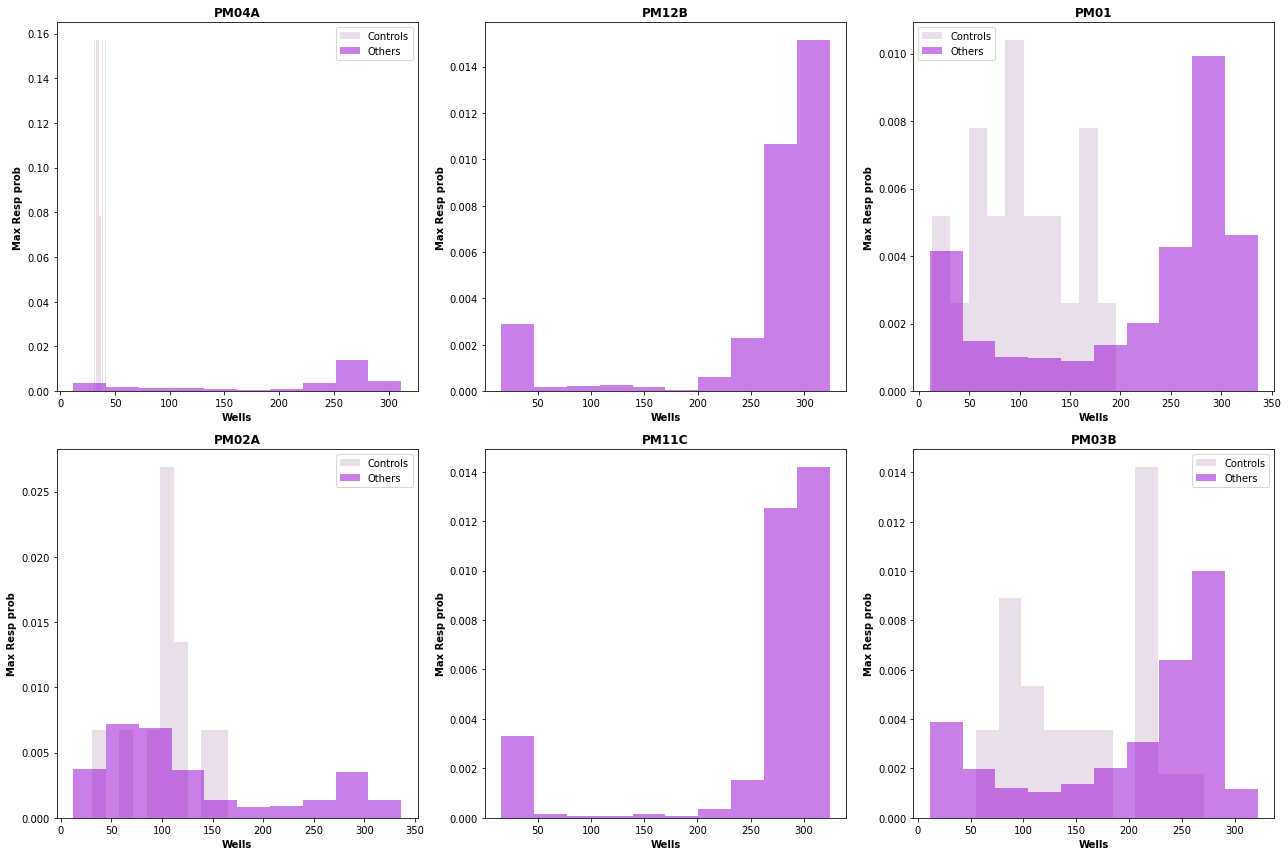

In [4]:
fig, axes = plt.subplots(len(all_plates_run) // 3, 3, figsize=(18, 6 * (len(all_plates_run) // 3)))

kinetic_parameters = pd.DataFrame()

for idx, plate in enumerate(all_plates_run):
    sample_file_names = get_plate_files(all_sample_files, plate, data_path)
    plate_df = make_plate_datatype(sample_file_names, data_path, plate)
    kinetic_df = get_kinetic_dataframe(plate_df)

    # Calculate the row and column indices for the subplot
    row = idx // 3
    col = idx % 3

    # Access the correct axis based on row and column
    ax = axes[row, col]

    if 'PM11' in plate or 'PM12' in plate:
        make_max_resp_histogram(kinetic_df, ax, negative_control=False)
    else:
        make_max_resp_histogram(kinetic_df, ax, negative_control=True)

    ax.set_title(plate,fontweight='bold')
    kinetic_parameters = pd.concat([kinetic_parameters, kinetic_df])

# Ensure any remaining subplots are removed if the number of plates is not a multiple of 3
for idx in range(len(all_plates_run), len(axes.flat)):
    fig.delaxes(axes.flat[idx])

plt.tight_layout()
plt.show()


#### Look at kinetic parameter correlations across samples

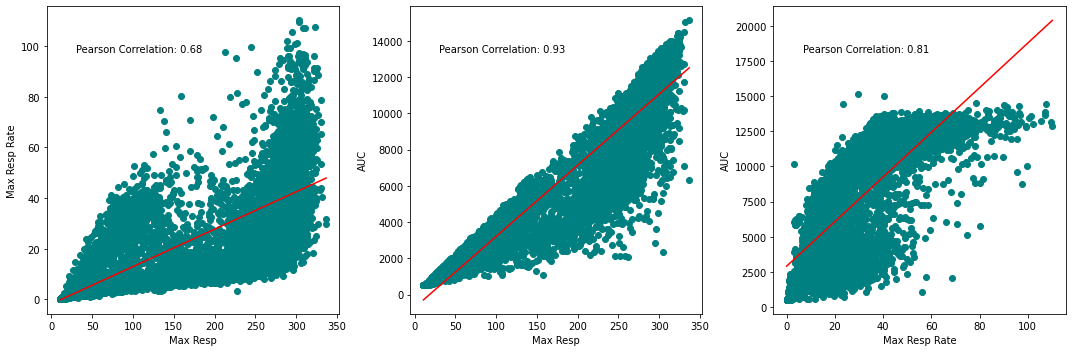

In [5]:
fig2, axes2 = plt.subplots(1, 3, figsize=(15, 5))

# Define the data for scatter plots
x_data = kinetic_parameters['Max Resp']
y_data = kinetic_parameters['Max Resp Rate']
z_data = kinetic_parameters['AUC']

for i, label in enumerate(['Max Resp vs Max Resp Rate', 'Max Resp vs AUC', 'Max Resp Rate vs AUC']):
    x = pd.to_numeric(y_data, errors='coerce').values if i == 2 else (pd.to_numeric(x_data, errors='coerce').values)
    y = pd.to_numeric(y_data, errors='coerce').values if i == 0 else (pd.to_numeric(z_data, errors='coerce').values)
    axes2[i].scatter(x, y,color='teal')
    axes2[i].set_ylabel('Max Resp Rate' if i == 0 else ('AUC' if i == 1 else 'AUC'))
    axes2[i].set_xlabel('Max Resp Rate' if i==2 else 'Max Resp')

    # Calculate the Pearson correlation coefficient
    corr_coeff, _ = pearsonr(x, y)
    
    # Add the correlation coefficient to the plot
    axes2[i].text(0.1, 0.85, f'Pearson Correlation: {corr_coeff:.2f}', transform=axes2[i].transAxes)

    # Calculate the linear regression line using linregress
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    # Add the regression line to the plot
    x_values = np.array([min(x), max(x)])
    y_values = slope * x_values + intercept
    axes2[i].plot(x_values, y_values, color='red')

# Adjust subplot layout and show the plot
plt.tight_layout()
plt.show()

#### Final growth calls and processed datatypes - kinetics + signals

In [6]:
'''
Go through every plate, make a dataframe of all strains and their signals for the plate.
Then, for every signal, get associated kinetic parameters and make a dataframe for it. 
Then, based on the z-score, make growth calls. Assign growth on a substrate if majority
of replicates grow on it.
'''

growth_calls = pd.DataFrame()
kinetic_parameters = pd.DataFrame()
plate_signals = pd.DataFrame()
bad_replicates_df = pd.DataFrame()
bad_replicate_plates = []
bad_replicate_strains = []

bad_controls_df = pd.DataFrame()
bad_control_strains = []
bad_control_plates = []

for plate in all_plates_run:
    sample_file_names = get_plate_files(all_sample_files,plate,data_path)
    
    plate_df = make_plate_datatype(sample_file_names,data_path,plate) #creates the plate datatype
    #Standardize strain names and media names :
    plate_df = fix_plate_entries(plate_df)
    
    plate_df, bad_replicates = remove_no_replicates(plate_df)
    if(len(bad_replicates)>0):
        bad_replicate_plates = bad_replicate_plates + [plate]*len(bad_replicates)
        bad_replicate_strains = bad_replicate_strains+bad_replicates
    
    kinetic_df = get_kinetic_dataframe(plate_df) #creates the kinetic parameter datatype
    if('PM11' in plate or 'PM12' in plate):
        kinetic_df = make_growth_calls(kinetic_df,negative_control=False)
        growth_df,_ = make_growth_datatype(kinetic_df,plate,negative_control=False)
    else:
        kinetic_df = make_growth_calls(kinetic_df)
        growth_df,bad_controls = make_growth_datatype(kinetic_df,plate)
        
        if(len(bad_controls)>0):
            bad_control_plates = bad_control_plates + [plate]*len(bad_controls)
            bad_control_strains = bad_control_strains+bad_controls
        
    growth_calls = pd.concat([growth_calls,growth_df])
    kinetic_parameters = pd.concat([kinetic_parameters,kinetic_df])
    plate_signals = pd.concat([plate_signals,plate_df])   
    
bad_replicates_df['Plate'] = bad_replicate_plates
bad_replicates_df['Strain'] = bad_replicate_strains
bad_controls_df['Plate'] = bad_control_plates
bad_controls_df['Strain'] = bad_control_strains

#### Visualize growth calls across plates

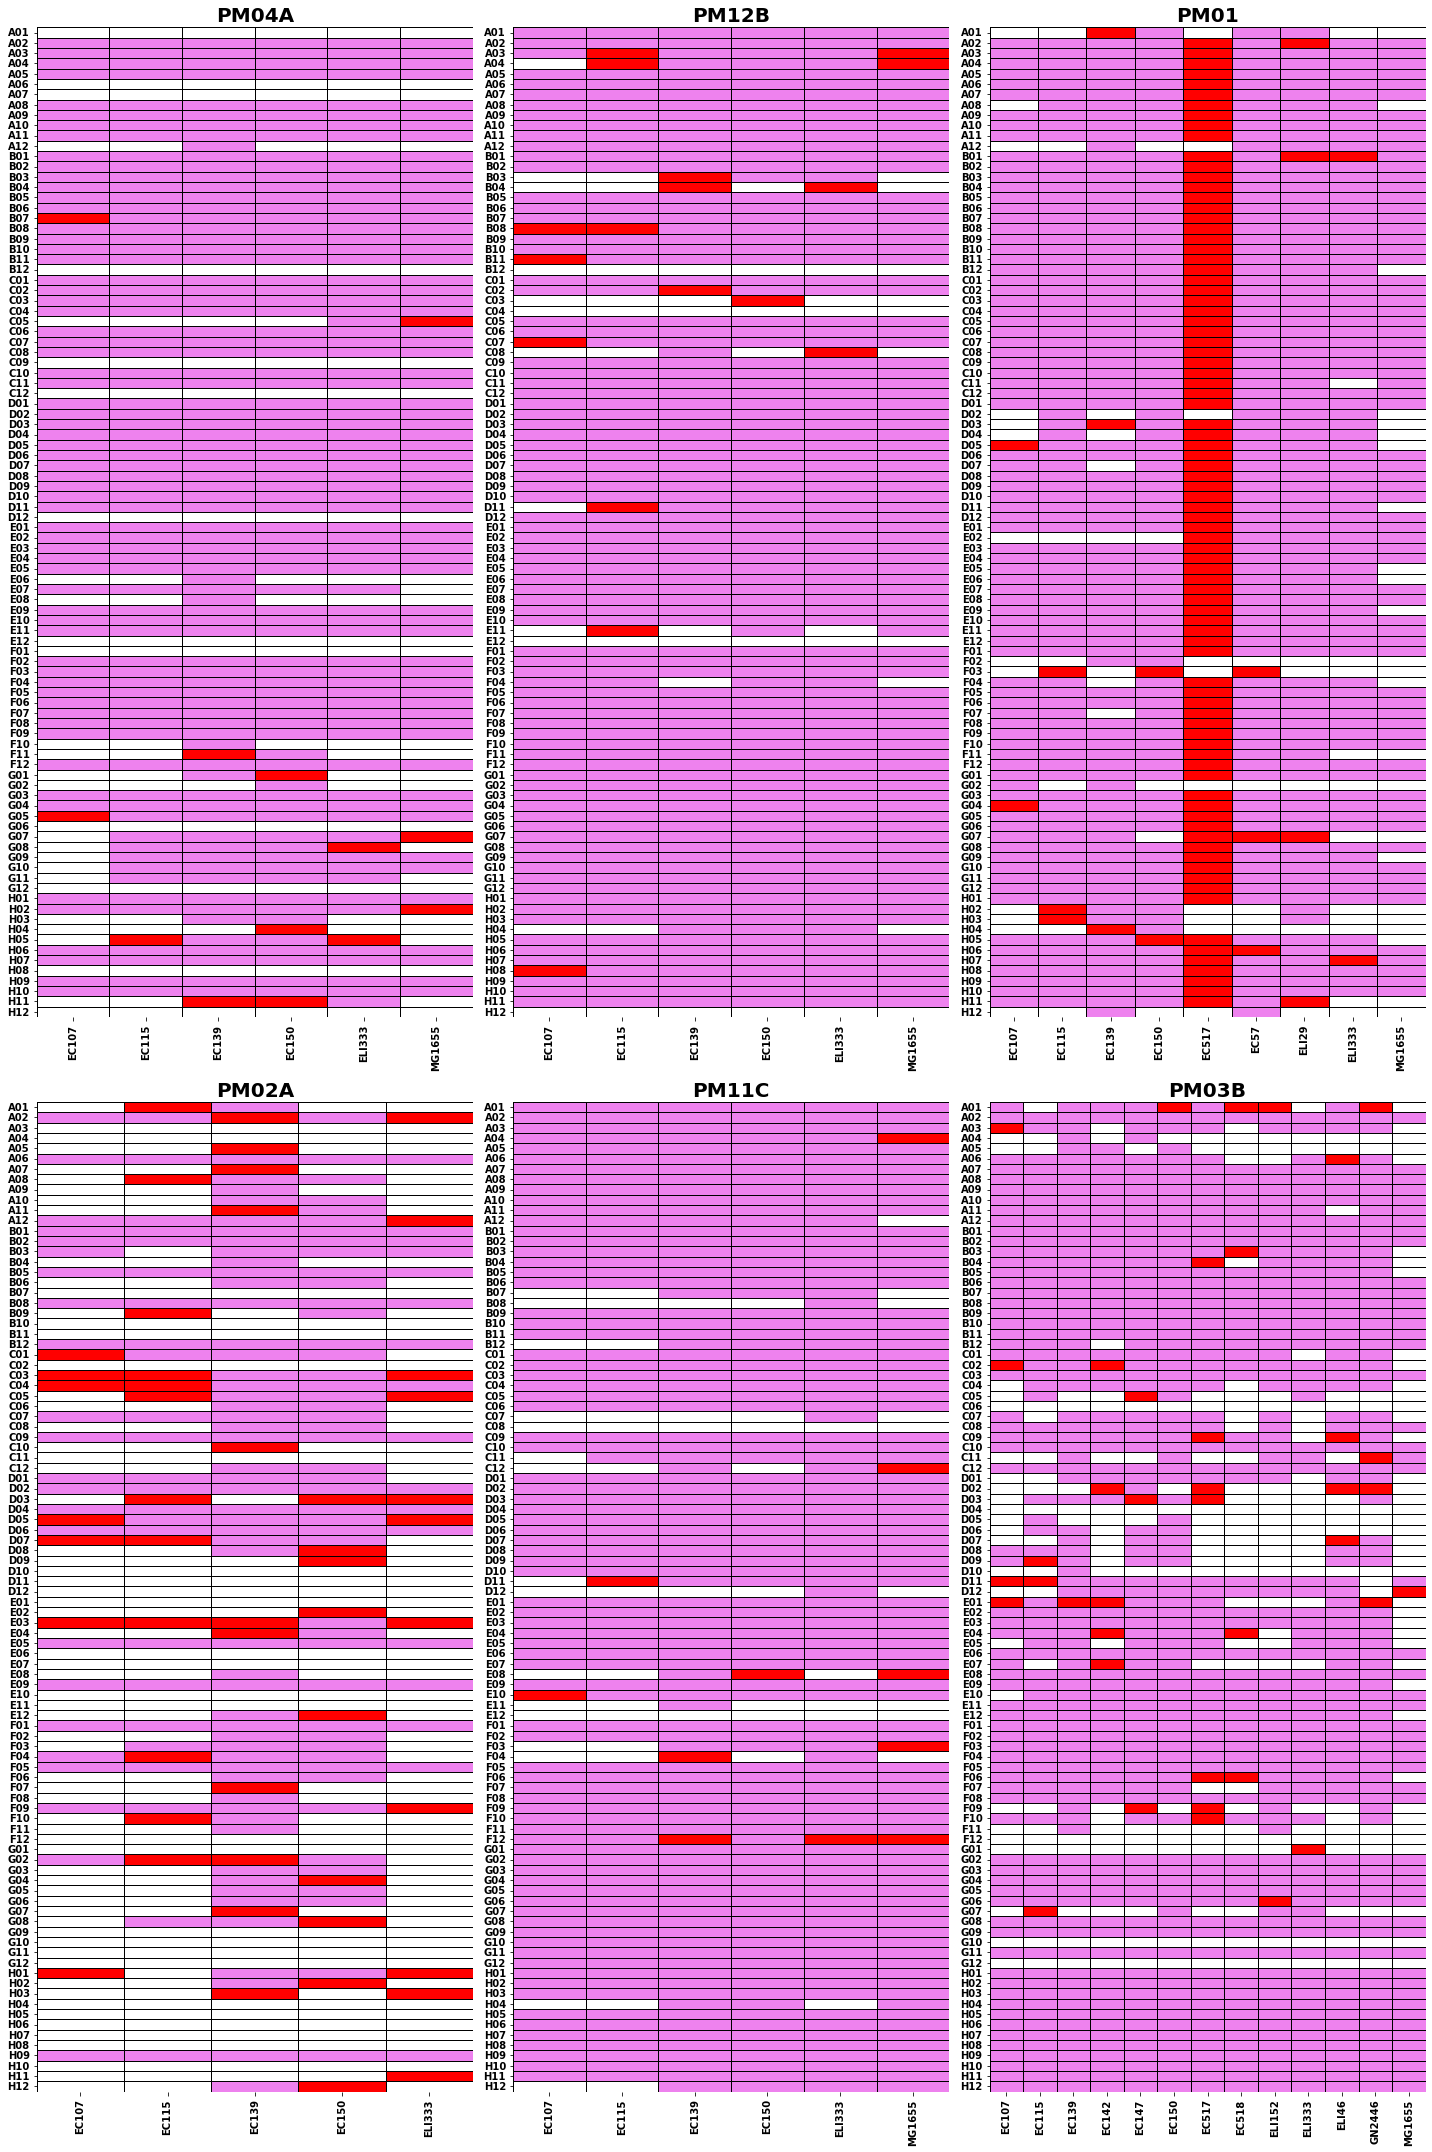

In [7]:
growth_dataframes = []


for plate in all_plates_run:
    temp_df = growth_calls.loc[growth_calls['Plate'] == plate]
    temp_df = temp_df.pivot(index='Well', columns='Strain', values='Growth')
    growth_dataframes.append(temp_df)

num_plots = len(growth_dataframes)
rows = int(math.sqrt(num_plots))
cols = int(math.ceil(num_plots / rows))

if num_plots == 1:
    fig, ax = plt.subplots(figsize=(20, 20))
    make_plate_heatmap(growth_dataframes[0], ax, cbar=False)
    ax.set_title(all_plates_run[0],fontweight='bold',fontsize=20)
else:
    fig, axes = plt.subplots(rows, cols, figsize=(20,30))
    for i in range(num_plots):
        row = i // cols
        col = i % cols
        ax = axes[row, col]
        make_plate_heatmap(growth_dataframes[i], ax, cbar=False)
        ax.set_title(all_plates_run[i],fontweight='bold',fontsize=20)

    # Hide any remaining empty subplots
    for i in range(num_plots, rows * cols):
        row = i // cols
        col = i % cols
        ax = axes[row, col]
        fig.delaxes(ax)
plt.tight_layout()
plt.show()


#### Examine and redo strong controls

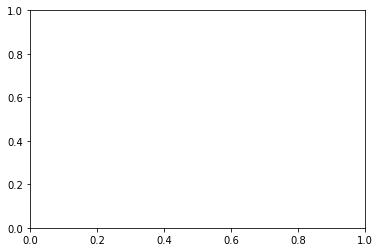

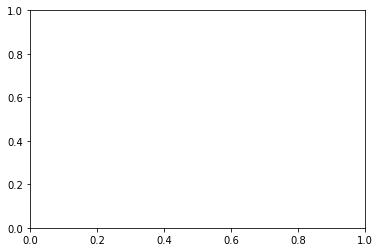

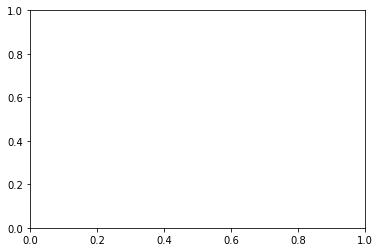

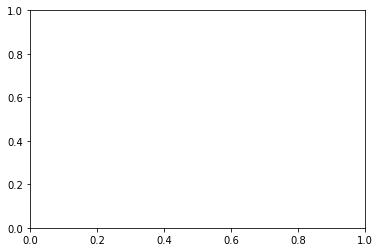

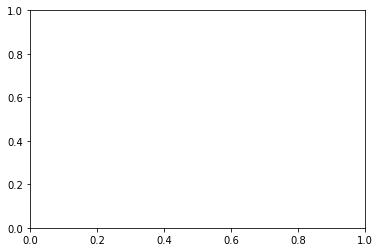

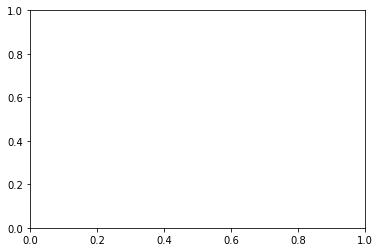

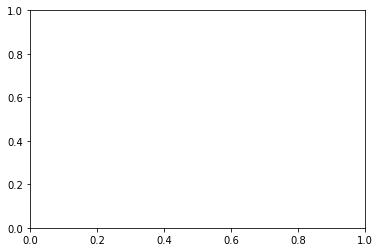

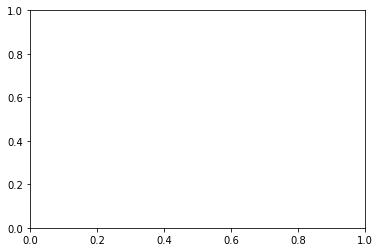

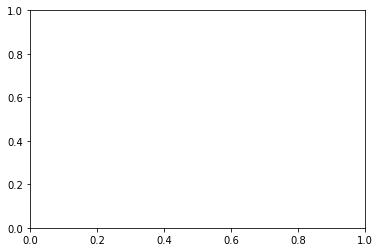

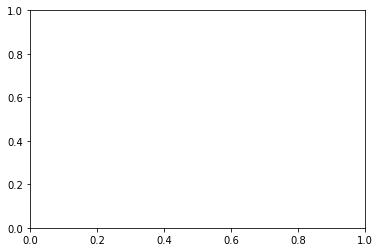

In [8]:
'''
Saves plots of all 'bad' controls - strains which have a high control signal. This does not mean the experiment
is bad, some strains have high NADH reduction signals, particularly clinical isolates. Examine their plots and take
a call whether to still include them in the analysis. Growth calls for them are made separately below
'''

#look at individual signals
#plot_high_background_noise(bad_controls_df,plate_signals,'noisy_controls')

#### Remove samples that need to be redone by examining the plots saved above

In [21]:
## Remove all control well data from plate_signals, kinetic_parameters and growth_calls
plate_signals,bad_control_signals = remove_bad_controls(plate_signals,bad_controls_df)
kinetic_parameters,bad_control_kinetics = remove_bad_controls(kinetic_parameters,bad_controls_df)
growth_calls, _ = remove_bad_controls(growth_calls,bad_controls_df)

###In bad_control_kinetics, check which sample types have a really high signal based on a threshold of 200

bad_strains = filter_bad_controls(bad_control_kinetics,threshold=200)

bad_strains

In [ ]:
for plate, strains in plate_strain_dict.items():
    mask = (bad_controls_df['Plate'] == plate) & (bad_controls_df['Strain'].isin(strains))
    bad_controls_df = bad_controls_df[~mask]
    
    
    
##Redo growth calls for high control signal wells
remade_growth_calls = pd.DataFrame()

for i in zip(bad_controls_df['Plate'],bad_controls_df['Strain']):
    bad_signals = bad_control_signals.loc[(bad_control_signals['Strain']==i[1])&(bad_control_signals['Plate']==i[0])]
    bad_kinetics = bad_control_kinetics.loc[(bad_control_kinetics['Strain']==i[1])&(bad_control_kinetics['Plate']==i[0])]
    strong_control_growth,new_kinetics = make_growth_calls_strong_controls(bad_kinetics)

    remade_growth_calls = pd.concat([remade_growth_calls,strong_control_growth])
    kinetic_parameters = pd.concat([kinetic_parameters,new_kinetics])
    growth_calls = pd.concat([growth_calls,strong_control_growth])
    plate_signals = pd.concat([plate_signals,strong_control_growth])